#  <center> Speech Emotion Recognition <center>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We are going to install pydub, this module provides us a enviorment where we can work with the audio files very smoothly, like export, split, merge audio files etc.

In [3]:
pip install pydub

# Importing Libraries

In [4]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio


from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Data Preparation
* As we are working with two different datasets, so i will be creating a dataframe storing all emotions of the data in dataframe with their paths.
* We will use this dataframe to extract features for our model training.
* I am using the Ravdess and Tess datasets for the task because :
1. Both of the consists of the high quality of audio in terms of sound
2. Also these datasets contains various types of emotion sounds which helps us to make our model more robust.

In [5]:
# Paths for data.
Ravdess_song = "/content/drive/MyDrive/Audio_Song_Actors_01-24"
Ravdess_speech = "/content/drive/MyDrive/Audio_Speech_Actors_01-24"

##  <center> 1. Ravdess Song Dataset <center>
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4
This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [6]:
ravdess_song_directory_list = os.listdir(Ravdess_song) # accesing the actor files

file_emotion = []
file_path = []
for dir in ravdess_song_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess_song + '/' + dir) # accesing the audio files
    for file in actor:
        part = file.split('.')[0] # exclude the .wav part in the audio files
        part = part.split('-') # extract the numbers of the name of the audio files
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        # Fix: Add a '/' between the directory and the file name
        file_path.append(Ravdess_song + '/' + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_song_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_song_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_song_df.head()

/tmp/ipython-input-6-4197735122.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Ravdess_song_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)


,Emotions,Path
0,calm,/content/drive/MyDrive/Audio_Song_Actors_01-24...
1,calm,/content/drive/MyDrive/Audio_Song_Actors_01-24...
2,neutral,/content/drive/MyDrive/Audio_Song_Actors_01-24...
3,calm,/content/drive/MyDrive/Audio_Song_Actors_01-24...
4,happy,/content/drive/MyDrive/Audio_Song_Actors_01-24...


##  <center> 3. RAVDESS  SPEECH dataset <center>

In [7]:
ravdess_speech_directory_list = os.listdir(Ravdess_speech) # accesing the actor files

file_emotion = []
file_path = []
for dir in ravdess_speech_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess_speech + '/' + dir) # accesing the audio files
    for file in actor:
        part = file.split('.')[0] # exclude the .wav part in the audio files
        part = part.split('-') # extract the numbers of the name of the audio files
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        # Fix: Add a '/' between the directory and the file name
        file_path.append(Ravdess_speech + '/' + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_speech_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_speech_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_speech_df.head()

/tmp/ipython-input-7-38314749.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Ravdess_speech_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)


,Emotions,Path
0,calm,/content/drive/MyDrive/Audio_Speech_Actors_01-...
1,calm,/content/drive/MyDrive/Audio_Speech_Actors_01-...
2,neutral,/content/drive/MyDrive/Audio_Speech_Actors_01-...
3,happy,/content/drive/MyDrive/Audio_Speech_Actors_01-...
4,sad,/content/drive/MyDrive/Audio_Speech_Actors_01-...


In [8]:
# creating Dataframe using all the 2 dataframes we created so far.
data_path = pd.concat([Ravdess_song_df,  Ravdess_speech_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.shape

(2452, 2)

## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

In [9]:
data_path.head()

,Emotions,Path
0,calm,/content/drive/MyDrive/Audio_Song_Actors_01-24...
1,calm,/content/drive/MyDrive/Audio_Song_Actors_01-24...
2,neutral,/content/drive/MyDrive/Audio_Song_Actors_01-24...
3,calm,/content/drive/MyDrive/Audio_Song_Actors_01-24...
4,happy,/content/drive/MyDrive/Audio_Song_Actors_01-24...


In [10]:
print(data_path['Emotions'].dtype)

object


In [11]:
data_path['Emotions'] = data_path['Emotions'].astype('category')

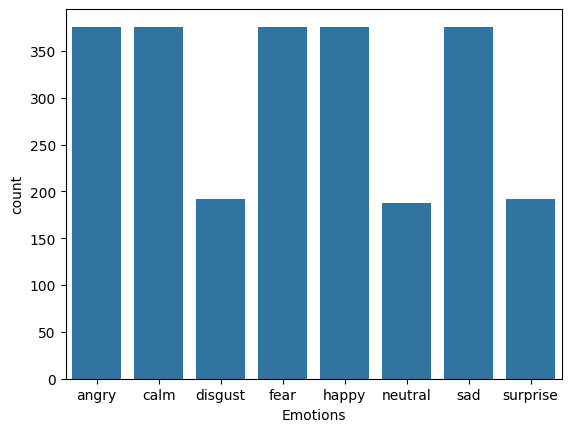

In [12]:
sns.countplot(x='Emotions', data=data_path)
plt.show()

We can also plot waveplots and spectograms for audio signals

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [13]:
def create_waveplot(y, sr, title):
    plt.figure(figsize=(8, 2))
    plt.title(title)
    librosa.display.waveshow(y, sr=sr)
    plt.show()


def create_spectrogram(data, sr):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

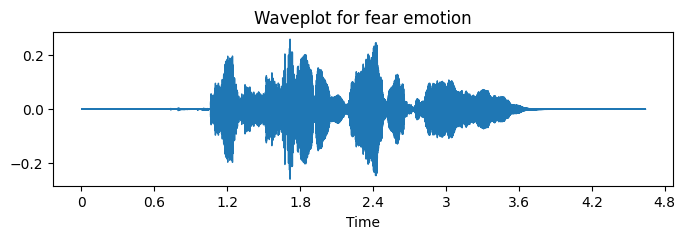

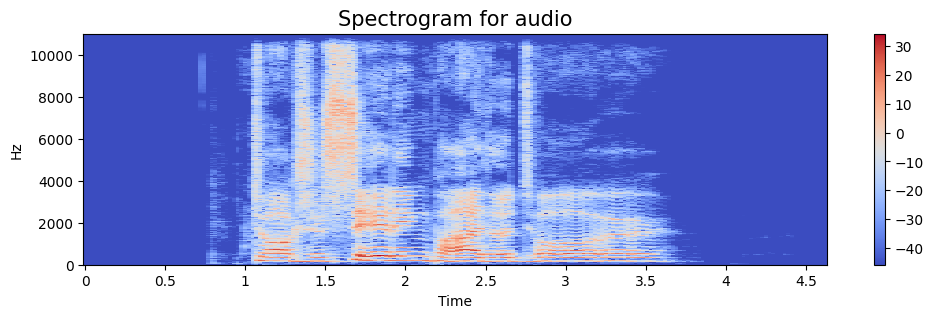

In [14]:
emotion_label = 'fear'
title = f"Waveplot for {emotion_label} emotion"
path = np.array(data_path.Path[data_path['Emotions'] == emotion_label])[1]
y, sr = librosa.load(path)
create_waveplot(y, sr, title)
create_spectrogram(y,sr)
Audio(path)

**Results :**
We found that except for angry emotion all other emotion files , the loudness of the sound is maximum in the 1 to 2.5 second , on the other hand for angry emotion it goes upto more than 3 second.

## Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.

In [15]:
def noise(data):
    noise_amp = 0.01*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=0.8)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data,sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate,n_steps=0.7)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

In [16]:
sample_rate

22050

#### 1. Simple Audio

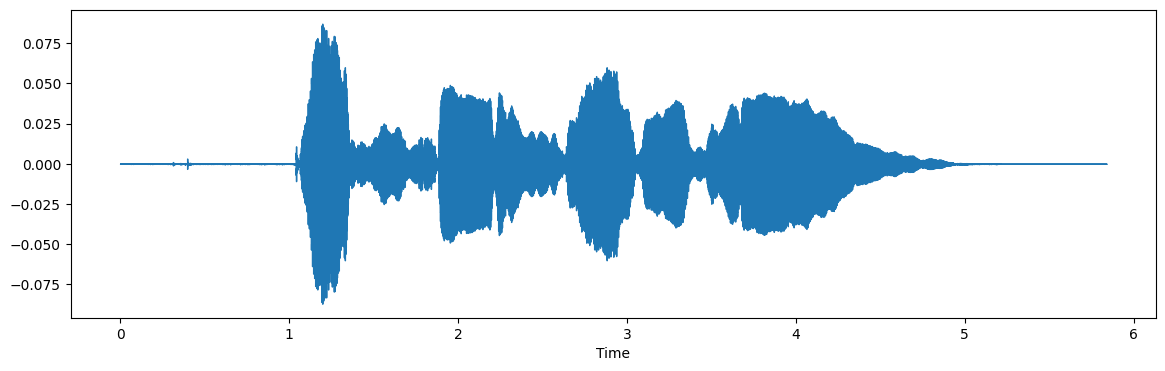

In [17]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

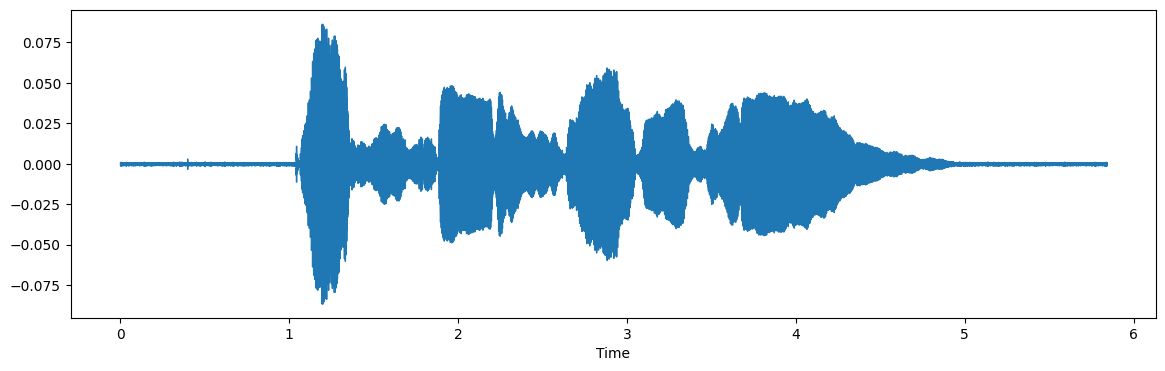

In [18]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted, alommake the model more robust to the background noise

#### 3. Stretching

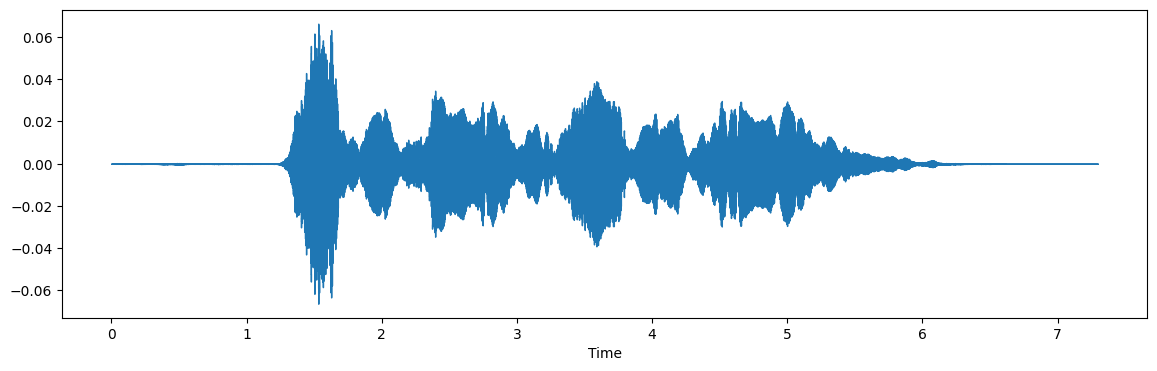

In [19]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

Streching degrades the quality of the sound, if we increases the speed of the sound than , we loose lots of infomation, or we become unable to detect them, but if slowed it , it degrades the quality of the sound . Here frequency is same.

#### 4. Shifting

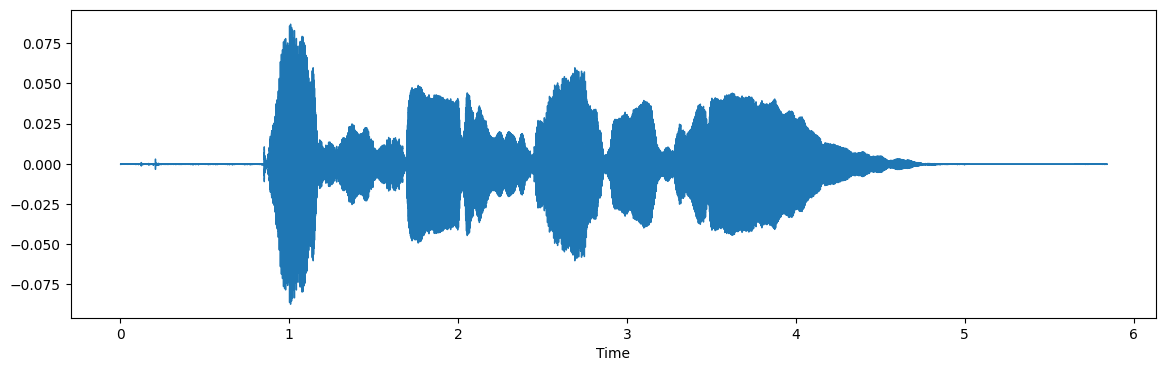

In [20]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

Works very fine, and we get the less scarsited data

#### 5. Pitch

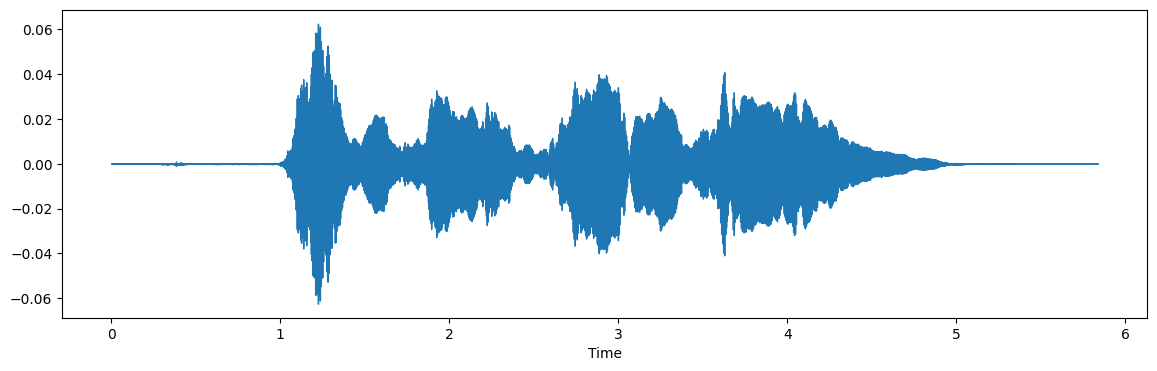

In [21]:
x = pitch(data,sr)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

Pitching try to change the pitch of the sound and after hearing the sound we can understand that it is trying to add some vibration type of sound for train the model.

- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching. Shifting just shifts the time axis, contributing to create least robustness to the model.

## Feature Extraction
- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.


The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

![image.png](https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg)

There are two types of features for the Audio analysis:
1. Supervised : MFCC, Chroma Features
2. Unsupervised : ZCR, RMS, Spectral centroid

It is very difficult to find the optimal features for any audio classification task due to high computation cost, experimentally it has been proven that a combination of supervised and unsupervised features are more efficient features( semi supervised features) for the model to become very diversifying in nature.

In this project , randomly i am only extracting 5 features:
- **Zero Crossing Rate** :ZCR measures the rate at which the audio signal changes its sign, providing information about the overall noisiness or percussiveness of the signal.
- **Chroma_stft**:Chroma_stft represents the energy distribution across different pitch classes, providing information about the pitch content in the audio. This is valuable for recognizing distinct pitch patterns in speech,
- **MFCC**:MFCCs are widely used for extracting spectral features, capturing the frequency content of the audio signal
- **RMS(root mean square) value**:RMS value reflects the energy content of the audio signal. In speech, it helps capture the overall loudness and intensity variations, which can be indicative of different speech segments or emotional states
- **MelSpectogram**:MelSpectrogram provides a visual representation of the frequency content over time, offering a more detailed view of the spectral characteristics of speech. It enhances the model's ability to recognize speech patterns by incorporating frequency information in a time-dependent manne

In [22]:
def extract_features(data,sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally 1.
    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally 13
    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally 33
    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally 34
    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally 162

    return result

In [23]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [24]:
print(data_path.shape)
data_path.head()

(2452, 2)


,Emotions,Path
0,calm,/content/drive/MyDrive/Audio_Song_Actors_01-24...
1,calm,/content/drive/MyDrive/Audio_Song_Actors_01-24...
2,neutral,/content/drive/MyDrive/Audio_Song_Actors_01-24...
3,calm,/content/drive/MyDrive/Audio_Song_Actors_01-24...
4,happy,/content/drive/MyDrive/Audio_Song_Actors_01-24...


In [25]:
data_path['Emotions'].value_counts()

,count
Emotions,
angry,376
calm,376
fear,376
happy,376
sad,376
disgust,192
surprise,192
neutral,188


In [26]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    print(path," : ",emotion)
    feature = get_features(path)
#     print(feature)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

/content/drive/MyDrive/Audio_Song_Actors_01-24/Actor_23/03-02-02-01-02-02-23.wav  :  calm
/content/drive/MyDrive/Audio_Song_Actors_01-24/Actor_23/03-02-02-02-02-01-23.wav  :  calm
/content/drive/MyDrive/Audio_Song_Actors_01-24/Actor_23/03-02-01-01-02-02-23.wav  :  neutral
/content/drive/MyDrive/Audio_Song_Actors_01-24/Actor_23/03-02-02-02-02-02-23.wav  :  calm
/content/drive/MyDrive/Audio_Song_Actors_01-24/Actor_23/03-02-03-01-02-01-23.wav  :  happy
/content/drive/MyDrive/Audio_Song_Actors_01-24/Actor_23/03-02-02-02-01-01-23.wav  :  calm
/content/drive/MyDrive/Audio_Song_Actors_01-24/Actor_23/03-02-02-01-01-02-23.wav  :  calm
/content/drive/MyDrive/Audio_Song_Actors_01-24/Actor_23/03-02-03-01-01-01-23.wav  :  happy
/content/drive/MyDrive/Audio_Song_Actors_01-24/Actor_23/03-02-03-01-01-02-23.wav  :  happy
/content/drive/MyDrive/Audio_Song_Actors_01-24/Actor_23/03-02-01-01-01-01-23.wav  :  neutral
/content/drive/MyDrive/Audio_Song_Actors_01-24/Actor_23/03-02-02-01-01-01-23.wav  :  calm
/

In [27]:
len(X), len(Y), data_path.Path.shape

(7356, 7356, (2452,))

In [28]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features1.csv', index=False)
Features.shape

(7356, 163)

* We have applied data augmentation and extracted the features for each audio files and saved them.

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [29]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [30]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [31]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5517, 162), (5517, 8), (1839, 162), (1839, 8))

In [32]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5517, 162), (5517, 8), (1839, 162), (1839, 8))

In [33]:
x_train.shape

(5517, 162)

In [34]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5517, 162, 1), (5517, 8), (1839, 162, 1), (1839, 8))

## Modelling

Using CNN as model for the training , because if you think we sending the wave and spectral representation of the audio files as input to the model , it is very much similar to the image classification task. For this only , before we reshape the inputs into the correct format.

In [35]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 162, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 81, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 81, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 41, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 41, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 21, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 557,288 (2.13 MB)

 Trainable params: 557,288 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - accuracy: 0.2189 - loss: 1.9753 - val_accuracy: 0.2996 - val_loss: 1.8241 - learning_rate: 0.0010
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3006 - loss: 1.7820 - val_accuracy: 0.3589 - val_loss: 1.6992 - learning_rate: 0.0010
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3211 - loss: 1.7169 - val_accuracy: 0.3660 - val_loss: 1.6081 - learning_rate: 0.0010
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3731 - loss: 1.6098 - val_accuracy: 0.4312 - val_loss: 1.4624 - learning_rate: 0.0010
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4226 - loss: 1.4943 - val_accuracy: 0.4502 - val_loss: 1.4270 - learning_rate: 0.0010
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4260 - loss: 1.5029 - val_accuracy: 0.4633 - val_loss: 1.3900 - learning_rate: 0.0010
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4730 - loss: 1.3872 - val_accura

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7441 - loss: 1.0571
Accuracy of our model on test data :  75.31266808509827 %


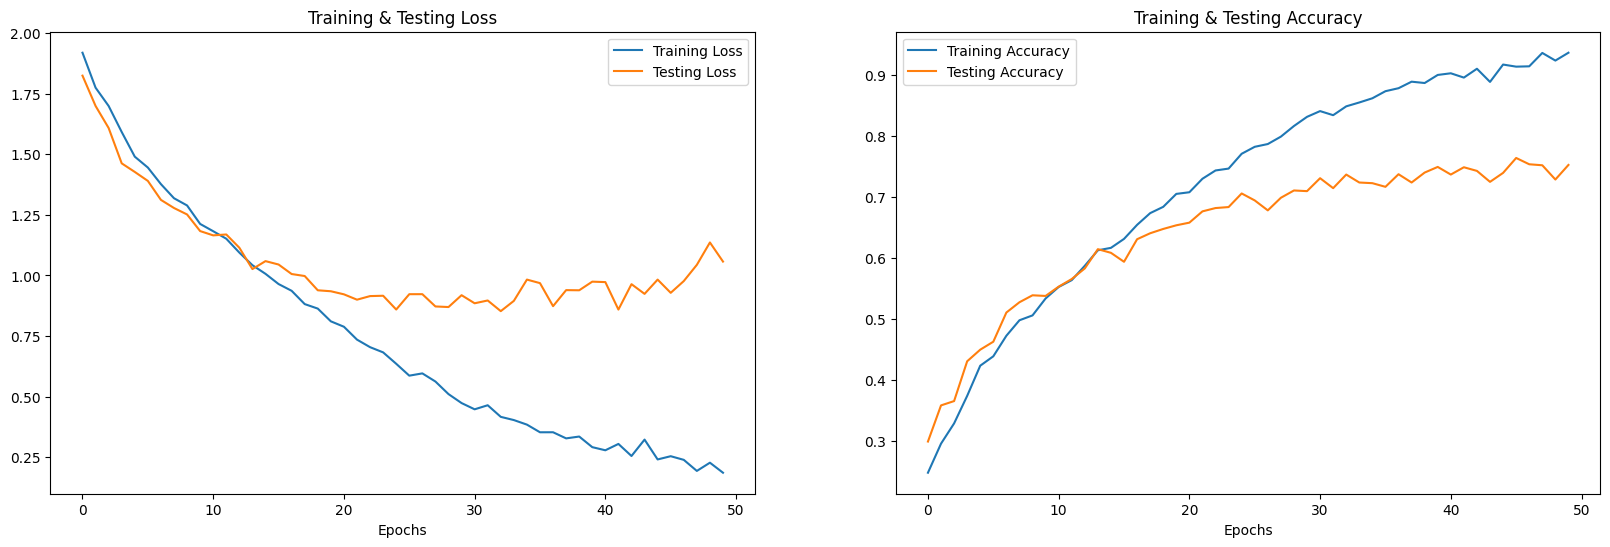

In [37]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

We are getting good accuracy by the model, I have tried also Autoencoders for this problem, but they don't work well , according to me , as the autoencoders converts the input into lower dimensional representation context vector , to get relevant information from the inputs , not like CNN who focuses on the entire input by focusing on the local features of the input, but as I have already removed the end and start part of the audio in deriving the features from the audio files, Autoencoders results in the information loss.

In [38]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [39]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,calm,calm
1,fear,fear
2,fear,fear
3,sad,sad
4,calm,calm
5,happy,fear
6,happy,angry
7,angry,angry
8,neutral,neutral
9,disgust,disgust


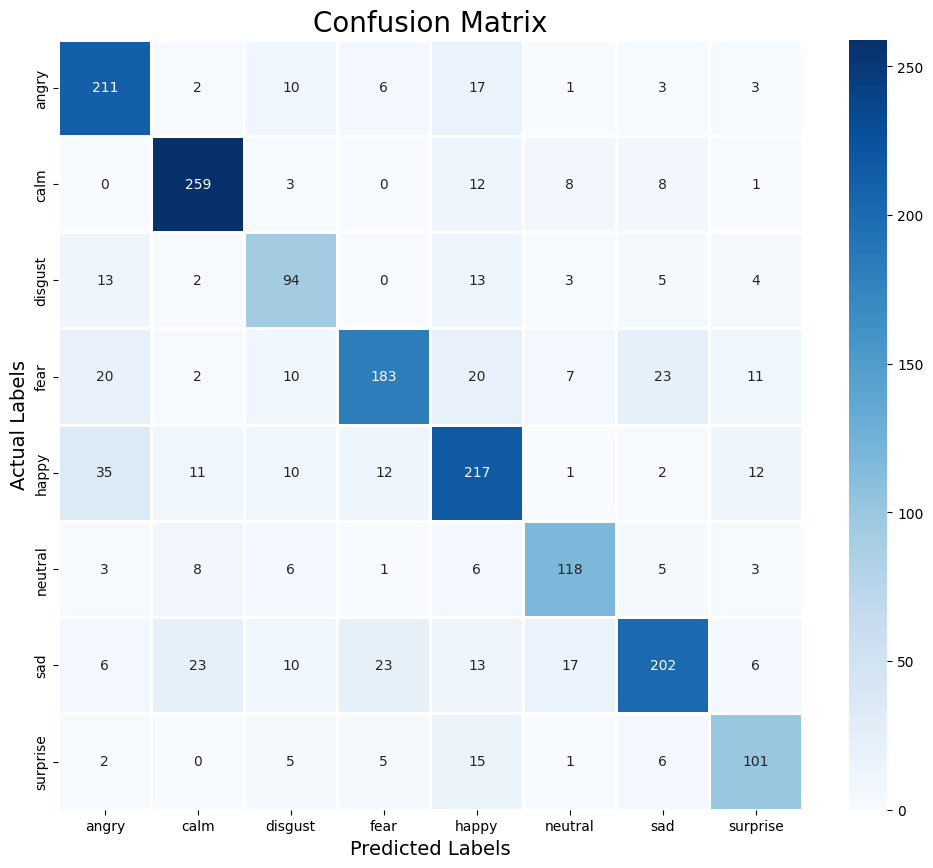

In [40]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.73      0.83      0.78       253
        calm       0.84      0.89      0.87       291
     disgust       0.64      0.70      0.67       134
        fear       0.80      0.66      0.72       276
       happy       0.69      0.72      0.71       300
     neutral       0.76      0.79      0.77       150
         sad       0.80      0.67      0.73       300
    surprise       0.72      0.75      0.73       135

    accuracy                           0.75      1839
   macro avg       0.75      0.75      0.75      1839
weighted avg       0.76      0.75      0.75      1839



In [43]:
model.save("Emotion_Audio.keras")